## **Import necessary libraries**

In [1]:
import numpy as np
import os
import json
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten,
                                     GlobalAveragePooling2D, BatchNormalization, Input)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LambdaCallback
from sklearn.metrics import confusion_matrix
%matplotlib inline


## **Load GPU if available**

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

## **Load train path, test path, data augmentation**

In [11]:
train_path = r"C:\Users\Anderson Yeo\Downloads\CS LAB PROJECT\OCT2017\train"
test_path = r"C:\Users\Anderson Yeo\Downloads\CS LAB PROJECT\OCT2017\test"

# Improved data augmentation and preprocessing
imgdata = ImageDataGenerator(
    rescale=1.0/255.0,             # Normalize the pixel values to the range [0, 1].
                                    # This make training process more stable and faster.
    validation_split=0.10,         # Reserves 10% of the data for validation.
    rotation_range=10,             # Randomly rotate images by up to 20 degrees.
    width_shift_range=0.1,         # Randomly shift images horizontally by up to 10% of the width.
    height_shift_range=0.1,        # Randomly shift images vertically by up to 10% of the height.
    shear_range=0.1,               # Apply shear transformation to the images.
    zoom_range=0.1,                # Randomly zoom in or out on the images.
    fill_mode='nearest',           # Fill in new pixels after transformations using the nearest pixel values.
    brightness_range=[0.9, 1.1],   # Randomly change brightness between 90%(darker) to 110%(brighter)
)

#Original data augmentation technique
#imgdata = ImageDataGenerator( rescale=1.0/255.0, validation_split=0.10)

# Adjusted batch size for limited RAM
batch_size = 16

train_batches = imgdata.flow_from_directory(train_path,class_mode='categorical', subset='training', target_size=(224, 224) ,
                                            classes = ['CNV','DME','DRUSEN','NORMAL'], batch_size = batch_size)
test_batches = imgdata.flow_from_directory(test_path, target_size=(224, 224) ,class_mode='categorical',
                                           classes = ['CNV','DME','DRUSEN','NORMAL'], batch_size = batch_size)
valid_batches = imgdata.flow_from_directory(train_path, subset='validation', target_size=(224, 224) ,class_mode='categorical',
                                            classes = ['CNV','DME','DRUSEN','NORMAL'], batch_size = batch_size)


Found 75138 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Found 8346 images belonging to 4 classes.


## **Visualize the data augmentation**

Found 83484 images belonging to 4 classes.


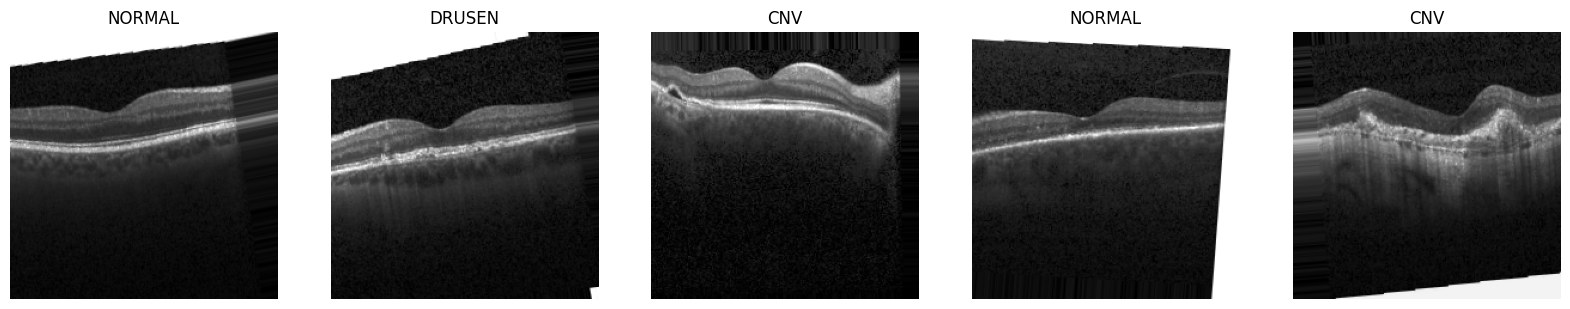

In [18]:
def visualize_augmentation(image_gen, path, class_labels, num_images=5):
    # Create an iterator for the images
    image_iterator = image_gen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=1,
        classes=class_labels,
        shuffle=True
    )

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        img, label = next(image_iterator)
        axes[i].imshow(img[0])
        axes[i].axis('off')
        axes[i].set_title(class_labels[np.argmax(label)])
    plt.show()

class_labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

visualize_augmentation(imgdata, train_path, class_labels)

## Lets try to see how many images do we have of each class and then use that to get the starting index of those images

In [19]:
mapper = {}
for label in train_batches.classes:
  if(label not in mapper):
    mapper[label] = 1
  else:
    val = mapper[label]
    mapper[label] = val+1
print(mapper)

{0: 33485, 1: 10214, 2: 7755, 3: 23684}


# Let's train on a prebuilt model: VGG16:
We will need to reshape the input so that we can feed our images that are bigger than what the model was trained on.

In [20]:
vgg16_model = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg16_model.trainable = False  # Freeze the layers of VGG16
#vgg16_model.layers.pop()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Create a sequential model and add all the layers in VGG16 to it. Then add the Dense layers for your custom output:

In [21]:
model= Sequential()
model.add(vgg16_model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## Add Dense layers

In [22]:
#Make the vgg16's layers non-trainable
#for layer in model.layers:
 # layer.trainable = False
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 14854372 (56.66 MB)
Trainable params: 139684 (545.64 KB)
Non-trainable params: 14714688 (56.13 MB)
_________

## Compile

In [23]:
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])

## Compute class weights

In [24]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_labels = np.unique(train_batches.classes)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_batches.classes)
class_weights_dict = dict(zip(class_labels, class_weights))


## Custom Callbacks

In [30]:
epoch_log_path = r'C:\Users\Anderson Yeo\Downloads\CS LAB PROJECT\OCT2017\epoch_log(2349spe).json'
history_log_path = r'C:\Users\Anderson Yeo\Downloads\CS LAB PROJECT\OCT2017\history_log(2349spe).json'
checkpoint_path = r"C:\Users\Anderson Yeo\Downloads\CS LAB PROJECT\OCT2017\model_vgg16_trained(2349spe).weights.h5"

def load_last_completed_epoch():
    try:
        with open(epoch_log_path, 'r') as file:
            data = json.load(file)
        return data['last_completed_epoch']
    except FileNotFoundError:
        return 0  # Return 0 if the log file doesn't exist

class CustomEpochCallback(Callback):
    def __init__(self, initial_epoch, total_epochs):
        super(CustomEpochCallback, self).__init__()
        self.initial_epoch = initial_epoch
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        # Adjust epoch count
        print(f"Epoch: {self.initial_epoch + epoch + 1}/{self.total_epochs}")

# Function to load the training history from the log file
def load_training_history():
    try:
        with open(history_log_path, 'r') as file:
            history = json.load(file)
        return history
    except FileNotFoundError:
        return None  # Return None if the log file doesn't exist

# Function to save the training history to the log file
def save_training_history(history):
    with open(history_log_path, 'w') as file:
        json.dump(history, file)

def log_epoch(epoch, logs):
    # Load existing log data
    if os.path.exists(epoch_log_path):
        with open(epoch_log_path, 'r') as file:
            data = json.load(file)
    else:
        data = {}

    # Update log data with the current epoch
    data['last_completed_epoch'] = epoch + 1
    with open(epoch_log_path, 'w') as file:
        json.dump(data, file)

class EpochLoggingCallback(Callback):
    def __init__(self, epoch_log_path, history_log_path, initial_epoch):
        super().__init__()
        self.epoch_log_path = epoch_log_path
        self.history_log_path = history_log_path
        self.initial_epoch = initial_epoch

    def on_epoch_end(self, epoch, logs=None):
        # Load existing log data or initialize it
        if os.path.exists(self.epoch_log_path):
            with open(self.epoch_log_path, 'r') as file:
                data = json.load(file)
        else:
            data = {'last_completed_epoch': self.initial_epoch}

        # Update the last completed epoch
        data['last_completed_epoch'] = self.initial_epoch + epoch + 1
        with open(self.epoch_log_path, 'w') as file:
            json.dump(data, file)

        # Load existing training history or initialize it
        if os.path.exists(self.history_log_path):
            with open(self.history_log_path, 'r') as file:
                history = json.load(file)
        else:
            history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        # Append current epoch's data to history
        for k, v in logs.items():
            if k in history:
                history[k].append(v)
            else:
                history[k] = [v]

        # Save the updated history
        with open(self.history_log_path, 'w') as file:
            json.dump(history, file)

# Create the callback instance
initial_epoch = load_last_completed_epoch()
epoch_history_callback = EpochLoggingCallback(epoch_log_path, history_log_path, initial_epoch)

total_epochs = 50
remaining_epochs = total_epochs - initial_epoch

## **Load model weights before resume training**
## (Run this code only when you want to resume training) 

In [31]:
# Load the model weights
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print("Weights loaded successfully.")
else:
    print(f"No checkpoint found at {checkpoint_path}")

No checkpoint found at C:\Users\Anderson Yeo\Downloads\CS LAB PROJECT\OCT2017\model_vgg16_trained(2349spe).weights.h5


## **Checkpoint**

In [32]:
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)


# **Training the modified VGG16 model on our data**
**NOTE:** Numbers are kept lower than predicted because of lower computational power and resource available!

In [33]:
history = model.fit(
    train_batches,
    steps_per_epoch=4696,
    epochs=remaining_epochs,
    verbose=1,
    validation_data=valid_batches,
    validation_steps=128,
    shuffle=True,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_callback, CustomEpochCallback(initial_epoch, total_epochs), epoch_history_callback]
)



Epoch: 1/5
Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 1.2069 - accuracy: 0.6450
Epoch 1: accuracy improved from -inf to 0.64500, saving model to C:\Users\Anderson Yeo\Downloads\CS LAB PROJECT\OCT2017\model_vgg16_trained(2349spe).weights.h5
200/200 [==============================] - 728s 4s/step - loss: 1.2069 - accuracy: 0.6450 - val_loss: 0.9329 - val_accuracy: 0.7012
Epoch: 2/5
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 1.0374 - accuracy: 0.6850
Epoch 2: accuracy improved from 0.64500 to 0.68500, saving model to C:\Users\Anderson Yeo\Downloads\CS LAB PROJECT\OCT2017\model_vgg16_trained(2349spe).weights.h5
200/200 [==============================] - 708s 4s/step - loss: 1.0374 - accuracy: 0.6850 - val_loss: 0.8377 - val_accuracy: 0.6733
Epoch: 3/5
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 0.9789 - accuracy: 0.6703
Epoch 3: accuracy did not improve from 0.68500
200/200 [==============================] - 680s 

## **Evaluate model on Test Data:**

In [34]:
acc = model.evaluate(test_batches, steps=len(test_batches), verbose=1)
print("accuracy: ", acc[1]*100)

63/63 [==============================] - 144s 2s/step - loss: 0.6459 - accuracy: 0.7350
accuracy:  73.50000143051147


# **Save the final model:**

In [35]:
model.save(checkpoint_path)
print("Saved model to disk")

ValueError: Unable to synchronously create dataset (name already exists)

## Save to json (optional)

In [ ]:
model_json = model.to_json()
with open("/content/drive/My Drive/Fundus_Image_Classification/model_vgg16_jsn_4labels.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_vgg16_wt.h5")
print("Saved model to disk")

Saved model to disk


## **Plot the Training and Validation Loss and Accuracy**

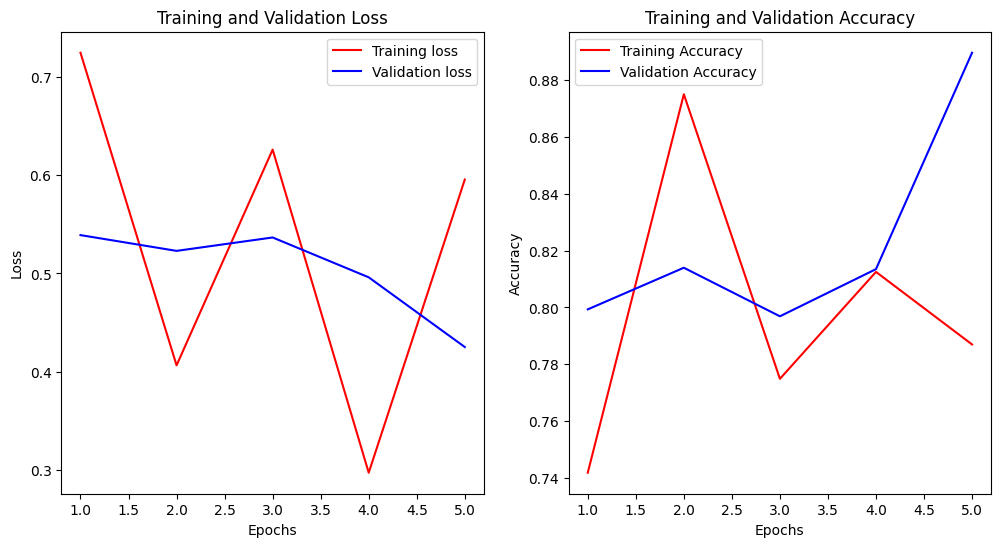

In [37]:
# Load the training history from the JSON file
with open(history_log_path, 'r') as file:
    history = json.load(file)

# Extract values for plotting
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## **Confusion matrix**

522/522 ━━━━━━━━━━━━━━━━━━━━ 930s 2s/step


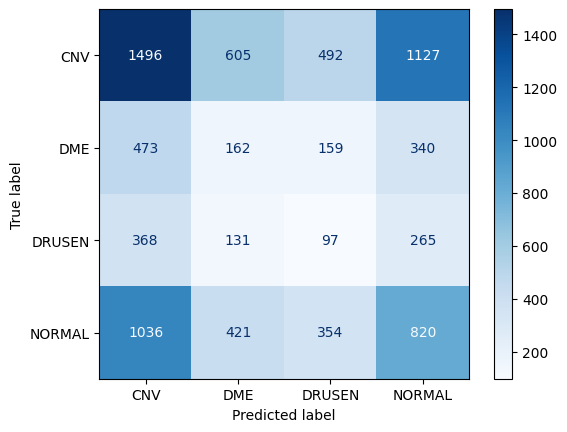

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Generating the confusion matrix
valid_batches.reset()  # Ensure the generator is at the start
valid_predictions = model.predict(valid_batches)
valid_pred_classes = np.argmax(valid_predictions, axis=1)
valid_true_classes = valid_batches.classes

cm = confusion_matrix(valid_true_classes, valid_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CNV', 'DME', 'DRUSEN', 'NORMAL'])
disp.plot(cmap=plt.cm.Blues)
plt.show()
